In [378]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import io
import re
import requests
import random
import seaborn as sns

def getYears(df):
    return df["Year"].unique()

def create_index(df, idx):
    total_events = df.shape[0]
    df[idx] = (
        df["Year"].astype(str)
        + "_"
        + df["Month"].astype(str).str.zfill(2)
        + "_"
        + df["latitude"].round(3).astype(str)
        + "_"
        + df["longitude"].round(3).astype(str)
        + "_"
        + [str(uuid.uuid4())[:8] for _ in range(total_events)]
    )
    return df

def classify_earthquake(row):
    try:
        mag = float(row["magnitude"])
        depth = float(row["depth"])
        gap = float(row["gap"])
        tsunami = int(row["tsunami"])
    except:
        return "Light"  # si hay error en datos, lo marcamos como leve

    # Light → sismos suaves o profundos
    if (mag < 5.2) or (mag < 5 and depth > 150):
        return "Light"

    # Medium → sismos moderados
    elif (5.2 <= mag < 6.8 and depth <= 200 and tsunami == 0):
        return "Medium"

    # Tough → magnitud alta o tsunami
    elif (mag >= 6.8) or (depth < 50) or (tsunami == 1):
        return "Tough"

    else:
        return "Light"  # aseguramos retorno siempre

def display_values(ax):
    total = sum([p.get_height() for p in ax.patches])
    for patch in ax.patches:
        height = patch.get_height()
        percentage = (height / total) * 100 if total > 0 else 0
        ax.text(
            patch.get_x() + patch.get_width() / 2,
            height + 1,
            f"{int(height)} ({percentage:.1f}%)",
            ha="center", va="bottom", fontsize=10
        )
    return ax

def full_info():
    return print("""#------ INFO ------#
# | Column        | Meaning                          | Unit / Scale                                                | Description                                                                                             |
# | ------------- | -------------------------------- | ----------------------------------------------------------- | ------------------------------------------------------------------------------------------------------- |
# | **magnitude** | Earthquake magnitude             | Richter or Moment Magnitude (Mw)                            | A measure of the energy released. Higher = stronger quake.                                              |
# | **cdi**       | *Community Determined Intensity* | I–X scale (Modified Mercalli Intensity, average from users) | Based on public “Did You Feel It?” reports. Reflects **felt intensity**.                                |
# | **mmi**       | *Modified Mercalli Intensity*    | I–X scale                                                   | Estimated shaking intensity from instruments, not people.                                               |
# | **sig**       | *Significance*                   | Numeric (0–1000)                                            | Composite score used by USGS to rank event importance (depends on magnitude, felt area, reports, etc.). |
# | **nst**       | *Number of Stations*             | Count                                                       | Number of seismic stations that detected and reported the event. More = higher accuracy.                |
# | **dmin**      | *Minimum Distance*               | Degrees (~111 km per degree)                                | Distance from epicenter to the nearest seismic station. Smaller = better accuracy.                      |
# | **gap**       | *Azimuthal Gap*                  | Degrees                                                     | Largest angle between stations around the epicenter. Smaller = better network coverage.                 |
# | **depth**     | *Hypocenter Depth*               | Kilometers (km)                                             | How deep below the Earth’s surface the earthquake occurred.                                             |
# | **latitude**  | Geographic coordinate            | Degrees                                                     | Latitude of the earthquake’s epicenter.                                                                 |
# | **longitude** | Geographic coordinate            | Degrees                                                     | Longitude of the earthquake’s epicenter.                                                                |
# | **Year**      | Year of occurrence               | Year (e.g. 2024)                                            | Extracted from the `time` field (or event timestamp).                                                   |
# | **Month**     | Month of occurrence              | Month (1–12)                                                | Useful for temporal trend analysis.                                                                     |
# | **tsunami**   | Tsunami alert flag               | 0 = No, 1 = Yes                                             | Whether the earthquake generated a tsunami.                                                             |

# 💡 Example Interpretations
# Example	Meaning
# magnitude = 6.2	Strong earthquake
# cdi = 7, mmi = 6.5	Very strong shaking, felt widely
# sig = 850	Significant event, possibly newsworthy
# nst = 130, dmin = 0.05, gap = 40	Very well-detected and precisely located
# depth = 12.0	Shallow earthquake (more damaging potential)
# tsunami = 1	Tsunami generated — typically near coastlines""")

def load_file(path: str):
    """
    Load a dataset from a local path or URL (including Google Drive).
    Supports CSV, Excel, JSON, Parquet, Feather, and Pickle formats.
    """
    # Map extensions to pandas functions
    extensions = {
        "csv": pd.read_csv,
        "xlsx": pd.read_excel,
        "xls": pd.read_excel,
        "json": pd.read_json,
        "parquet": pd.read_parquet,
        "feather": pd.read_feather,
        "pickle": pd.read_pickle,
    }

    url_pattern = r"^https?:\/\/"

    # If it's a URL
    if re.match(url_pattern, path):
        # Handle Google Drive links
        if "drive.google.com" in path:
            file_id = re.search(r"/d/([a-zA-Z0-9_-]+)", path)
            if file_id:
                path = f"https://drive.google.com/uc?id={file_id.group(1)}"

        # Download content
        response = requests.get(path)
        if response.status_code != 200:
            raise ValueError(f"Error {response.status_code} while accessing URL: {path}")

        # Guess file extension
        extension_match = re.search(r"\.(\w+)(?:\?|$)", path)
        extension = extension_match.group(1).lower() if extension_match else "csv"

        # Read file based on extension
        if extension in ["csv", "txt"]:
            df = pd.read_csv(io.StringIO(response.content.decode("utf-8")))
        elif extension in ["xlsx", "xls"]:
            df = pd.read_excel(io.BytesIO(response.content))
        elif extension == "json":
            df = pd.read_json(io.StringIO(response.content.decode("utf-8")))
        else:
            raise ValueError(f"Unsupported extension in URL: '{extension}'")

    # If it's a local file
    else:
        extension = path.split(".")[-1].lower()
        if extension not in extensions:
            raise ValueError(f"Unsupported file type: {extension}")
        df = extensions[extension](path)

    return df


def replaceAllEmptyByNA(df: pd.DataFrame) -> pd.DataFrame:
    """
    Replace all types of empty/invalid values in the entire DataFrame with pd.NA.
    """
    # Convert columns to best dtype
    df = df.convert_dtypes()

    # Trim spaces in string columns
    df = df.apply(lambda col: col.str.strip() if col.dtype == "string" else col)

    # Replace common "empty" values
    df = df.replace(r"^\s*$", pd.NA, regex=True)  # "", " ", "   "
    df = df.replace({"None": pd.NA, "nan": pd.NA, "NaN": pd.NA})

    return df


def get_mode(col: pd.Series, as_string: bool = False):
    """
    Returns the mode of a column safely.
    - Ignores NA
    - Returns first if multiple
    - Returns None if empty
    """
    col = col.dropna()
    if col.empty:
        return None

    moda = col.mode()
    if moda.empty:
        return None

    val = moda.iloc[0]
    return str(val) if as_string else val


def count_empty_values(col: pd.Series) -> int:
    """Count how many missing values (pd.NA / NaN) are in a column."""
    return col.isna().sum()


def checkIfEmpty(df: pd.DataFrame) -> None:
    """Print a summary if the DataFrame is empty or not."""
    if df.empty:
        print("⚠️ The DataFrame is empty.")
    else:
        print(f"✅ Data loaded successfully: {len(df)} rows, {len(df.columns)} columns.")


def countWhiteSpacesRows(field: pd.Series) -> int:
    """Count how many cells contain whitespace characters."""
    return field.apply(lambda x: any(ch.isspace() for ch in str(x)) if isinstance(x, str) else False).sum()

## Checking and data clean 😎🔎
- Load file
- Check null values
- Have as a guiance a full map info
- Ensure that replacing all empty data by NA to avoid errors after using this following functions: fillna, dropna, isna

In [379]:
# Load dataset
df = load_file("earthquake_data_tsunami.csv")

In [380]:
# Check null values
count_empty_values(df)

magnitude    0
cdi          0
mmi          0
sig          0
nst          0
dmin         0
gap          0
depth        0
latitude     0
longitude    0
Year         0
Month        0
tsunami      0
dtype: int64

In [381]:
full_info()

#------ INFO ------#
# | Column        | Meaning                          | Unit / Scale                                                | Description                                                                                             |
# | ------------- | -------------------------------- | ----------------------------------------------------------- | ------------------------------------------------------------------------------------------------------- |
# | **magnitude** | Earthquake magnitude             | Richter or Moment Magnitude (Mw)                            | A measure of the energy released. Higher = stronger quake.                                              |
# | **cdi**       | *Community Determined Intensity* | I–X scale (Modified Mercalli Intensity, average from users) | Based on public “Did You Feel It?” reports. Reflects **felt intensity**.                                |
# | **mmi**       | *Modified Mercalli Intensity*    | I–X scale                       

In [382]:
df = replaceAllEmptyByNA(df)

df.nunique()

df.duplicated().sum()

0

### Management and calculus ⚖️ 📶

#### Management 📃

Manage data and do calculus once previous stage is done. This is all about knowing behaviour and get used to it and what's more get on with data well.

- To begin with, as there is not a column which makes each data as unique, we will create a index combined with this following fields
  - Year
  - Month
  - latitude
  - longitude

Rarely, got to see something like this. It is more normal to create an index using timestamp. In this case, there is not a timestamp field so we decide to use this four fields. By far, they are closest to be each other unique. To grow into that, the random is the solution. It would turn out just like this: 

  - Field named "id_event" created by create_index function

- Later on, as we need to handle evolution and temporaly calculus, we got to create a new column named event_date which contains Year and Month column parsed into datetime to use it as index.It will ensure that working resample well. 
- To end with, set global variables "total_events" and "years" which they will be useful for the workflow
 
#### Basic and advanced calculus 🤓

- Basic statistics about magnitude and depth columns
- Top 10 earthquakes by magnitude
- Calculate overall mean and standard deviation
- Show earthquakes closest to the average (most typical magnitudes)
- Show the most dispersed earthquakes (further from the average)
- Detect and display real outliers with the interquartile range (IQR) rule


In [383]:
# There is not a unique id so we create a id
# First we parse month and year to string and latitude and longitude too
import random

total_events = df.shape[0]

import uuid

# Total number of events
total_events = df.shape[0]

# Create unique ID by combining information and a short hash
df = create_index(df, "id_event")
# Generate date column combined by month and year

df["event_date"] = df["Year"].astype(str)+"/"+df["Month"].astype(str)

df["event_date"] = pd.to_datetime(df["event_date"], format="%Y/%m")

df = df.set_index("event_date")

years = getYears(df)

In [384]:
# Basic statistics about magnitude and depth columns
stats_data = {
    'Metric': [
        'Mean Magnitude',
        'Median Magnitude',
        'Mode Magnitude',
        'Std Dev (Depth)',
        'Correlation Magnitude-Depth'
    ],
    'Value': [
        df["magnitude"].mean(),
        df["magnitude"].median(),
        get_mode(df["magnitude"]),
        df["depth"].std(),
        df["magnitude"].corr(df["depth"])
    ]
}

stats_df = pd.DataFrame(stats_data)
display(stats_df)

,Metric,Value
0,Mean Magnitude,6.925780
1,Median Magnitude,6.800000
2,Mode Magnitude,6.500000
3,Std Dev (Depth),137.277078
4,Correlation Magnitude-Depth,0.039480


In [385]:
# Top 10 earthquakes by magnitude
top10 = df.sort_values("magnitude", ascending=False).head(10)
display(top10[["magnitude","depth","gap","sig","tsunami"]])

,magnitude,depth,gap,sig,tsunami
event_date,,,,,
2004-12-01,9.1,30.0,22.0,1274,0
2011-03-01,9.1,29.0,9.5,2184,0
2010-02-01,8.8,22.9,17.8,1991,0
2012-04-01,8.6,20.0,16.6,2048,0
2005-03-01,8.6,30.0,22.1,1138,0
2007-09-01,8.4,34.0,32.3,1086,0
2001-06-01,8.4,33.0,0.0,1086,0
2006-11-01,8.3,10.0,20.9,1064,0
2015-09-01,8.3,22.44,19.0,1960,1


In [386]:
# Calculate overall mean and standard deviation
mean_mag = df["magnitude"].mean()
std_mag = df["magnitude"].std()

data_set = {
    'Overall Mean Magnitude': mean_mag,
    'Overall Std Dev Magnitude': std_mag
}

display(pd.DataFrame(data_set, index=[0]))

group_stats = df.groupby("tsunami")["magnitude"].agg(["mean","std","min","max","median"])
display(group_stats)

,Overall Mean Magnitude,Overall Std Dev Magnitude
0,6.92578,0.503532


,mean,std,min,max,median
tsunami,,,,,
0,6.917699,0.548789,2.7,9.1,6.8
1,6.938487,0.42325,6.5,8.3,6.8


In [387]:
# Show earthquakes closest to the average (most typical magnitudes)
df["dist_from_mean"] = abs(df["magnitude"] - mean_mag)
closest_to_mean = df.nsmallest(10, "dist_from_mean")[["magnitude","depth","gap","sig","tsunami"]]
display("Earthquakes closest to the global average:")
display(closest_to_mean)

'Earthquakes closest to the global average:'

,magnitude,depth,gap,sig,tsunami
event_date,,,,,
2022-09-01,6.9,10.0,34.0,887,1
2022-05-01,6.9,10.0,45.0,733,1
2022-03-01,6.9,10.0,42.0,738,1
2021-10-01,6.9,51.6,0.0,995,1
2021-10-01,6.9,535.0,31.0,740,1
2021-08-01,6.9,93.0,54.0,741,1
2021-08-01,6.9,16.7,48.0,734,1
2021-08-01,6.9,33.3,0.0,738,1
2021-08-01,6.9,20.74,36.0,738,1


In [388]:
# Show the most dispersed earthquakes (further from the average)
farthest_from_mean = df.nlargest(10, "dist_from_mean")[["magnitude","depth","gap","sig","tsunami"]]
display("Earthquakes farthest from the average (most atypical):")
display(farthest_from_mean)

'Earthquakes farthest from the average (most atypical):'

,magnitude,depth,gap,sig,tsunami
event_date,,,,,
2022-03-01,2.7,28.0,43.0,708,0
2022-09-01,3.6,12.0,34.0,1043,0
2022-11-01,3.9,25.0,34.0,735,0
2021-05-01,4.7,10.0,45.0,694,0
2011-03-01,9.1,29.0,9.5,2184,0
2004-12-01,9.1,30.0,22.0,1274,0
2010-02-01,8.8,22.9,17.8,1991,0
2012-04-01,8.6,20.0,16.6,2048,0
2005-03-01,8.6,30.0,22.1,1138,0


In [389]:
# Detect and display real outliers with the interquartile range (IQR) rule
Q1 = df["magnitude"].quantile(0.25)
Q3 = df["magnitude"].quantile(0.75)
IQR = Q3 - Q1

# Allowed range
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df[(df["magnitude"] < lower_bound) | (df["magnitude"] > upper_bound)]

display(f"Allowed range: {lower_bound:.2f} - {upper_bound:.2f}")
display(f"Outliers detected: {outliers.shape[0]}")

display(outliers[["magnitude","depth","gap","sig","tsunami"]])

'Allowed range: 5.85 - 7.85'

'Outliers detected: 41'

,magnitude,depth,gap,sig,tsunami
event_date,,,,,
2022-11-01,3.9,25.0,34.0,735,0
2022-09-01,3.6,12.0,34.0,1043,0
2022-03-01,2.7,28.0,43.0,708,0
2021-08-01,8.1,22.79,78.0,1009,0
2021-07-01,8.2,46.66,66.0,1237,1
2021-07-01,8.2,35.0,0.0,1252,1
2021-05-01,4.7,10.0,45.0,694,0
2021-03-01,8.1,28.93,21.0,1021,1
2019-05-01,8.0,122.57,17.0,1890,1


### Visualization 🎯 📈

Definitely, this is the end part of dataflow. Let's represent all both implicit and explicit data through different kind of calculus.

- Monthly evolution of magnitude: At first, it orders whatever year by input provided that it exists in dataset. Afterwards, it builds a dataframe filtered by year. To end with, it represents a basic plot displaying the evolution by month, but only for the year filtered. 
- Annual Magnitude Evolution: it represents a basic plot displaying the evolution of magnitudes by year
- Magnitude mean by month: it represents a basic plot displaying the mean of magnitudes by month. At first, it orders whatever year by input provided that it exists in dataset. Afterwards, it builds a dataframe filtered by year. To end with respect to the representation. 

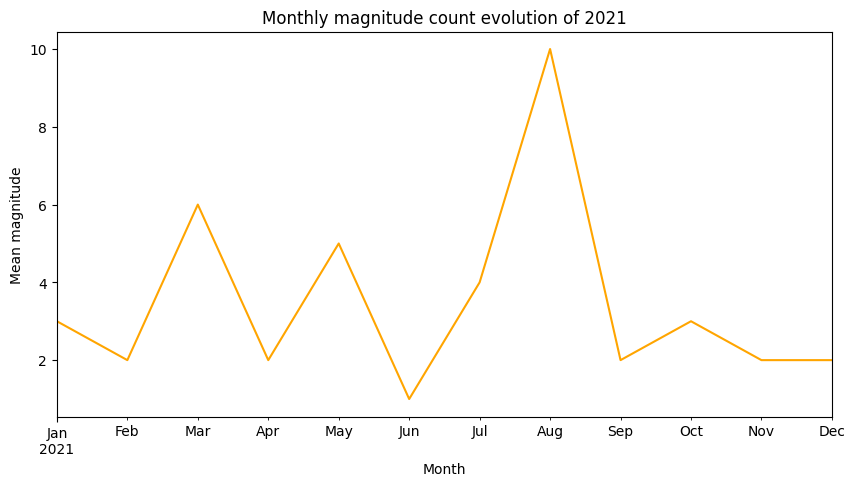

In [390]:
# Monthly evolution of magnitude
try:

    year = int(input(f"Type years {",".join(map(str, years ))}"))

    if year not in years:
        raise Exception("Not found year in dataset")

    df_magnitude_year = df[df["Year"] == year]

    monthly_mag_count = df_magnitude_year["magnitude"].resample("ME").count()

    monthly_mag_count.plot(
        figsize=(10,5),
        color="orange",
        title=f"Monthly magnitude count evolution of {year}",
        ylabel="Mean magnitude",
        xlabel="Month",
    )
    plt.show()
except Exception as e:
    display(e)
except NameError as e:
    print(e)
except ValueError as e:
    print(e)
except KeyboardInterrupt as e:
    print(e)

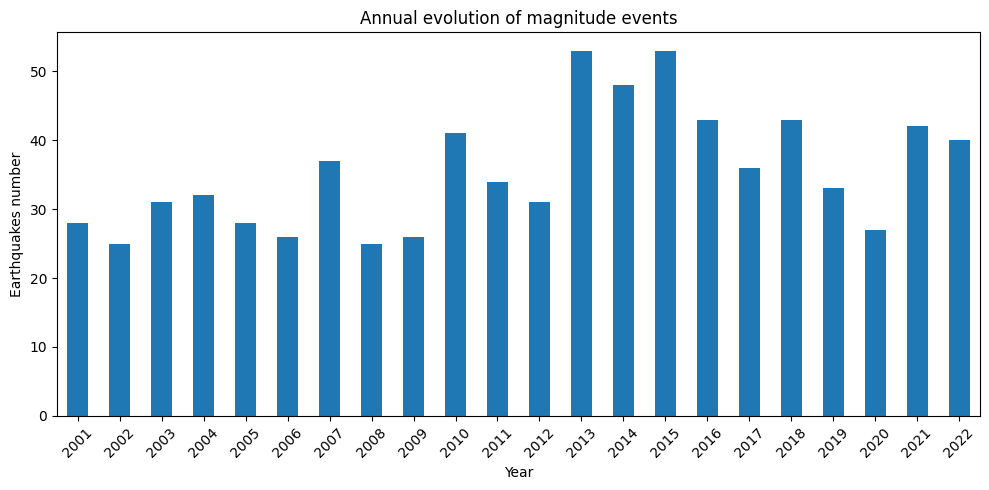

In [391]:
# Annual evolution of magnitude
annual_counts = df["magnitude"].resample("YE").count()

annual_counts.index = annual_counts.index.year # Access to year and only choose one
annual_counts = annual_counts.sort_index() # sort index ascending

annual_counts.plot(
    kind="bar",
    figsize=(10,5),
    title="Annual evolution of magnitude events",
)

plt.xlabel("Year")
plt.ylabel("Earthquakes number")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

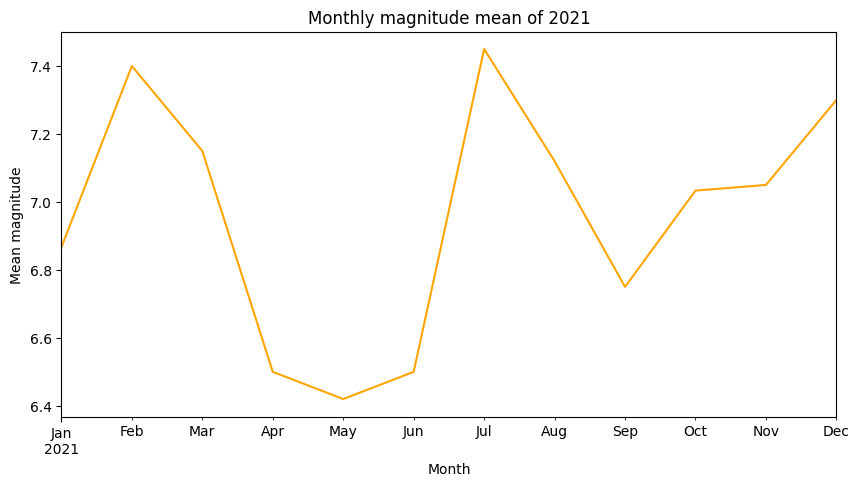

In [392]:
# Magnitude mean by month
try:

    year = int(input(f"Type years {",".join(map(str, years ))}"))

    if year not in years:
        raise Exception("Not found year in dataset")

    df_magnitude_year = df[df["Year"] == year]

    monthly_mag_mean = df_magnitude_year["magnitude"].resample("ME").mean()

    monthly_mag_mean.plot(
        figsize=(10,5),
        color="orange",
        title=f"Monthly magnitude mean of {year}",
        ylabel="Mean magnitude",
        xlabel="Month",
    )
    plt.show()
except Exception as e:
    display(e)
except NameError as e:
    print(e)
except ValueError as e:
    print(e)
except KeyboardInterrupt as e:
    print(e)

2.7

magnitude          0
cdi                0
mmi                0
sig                0
nst                0
dmin               0
gap                0
depth              0
latitude           0
longitude          0
Year               0
Month              0
tsunami            0
id_event           0
dist_from_mean     0
rating_advanced    0
dtype: int64

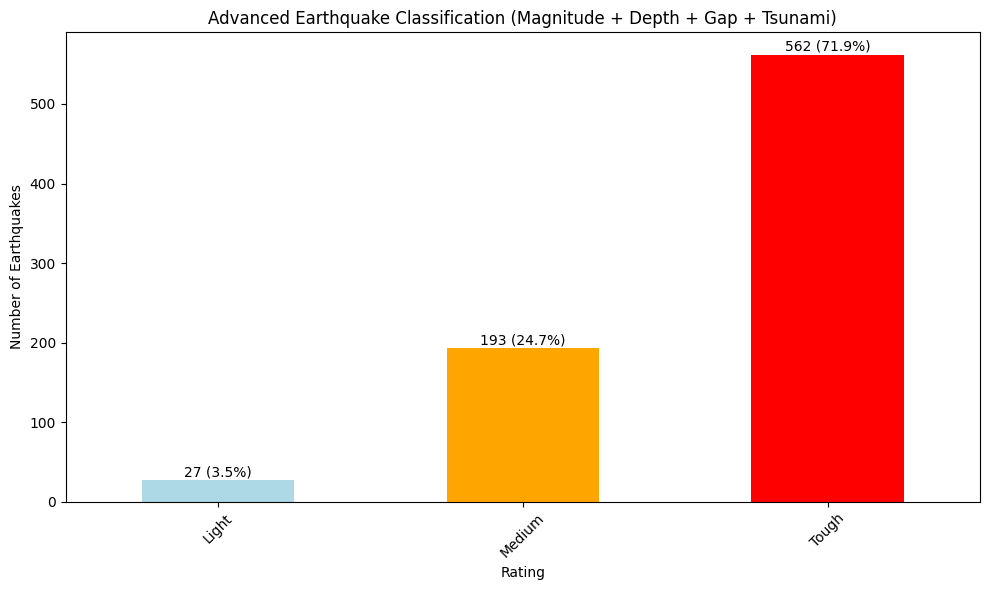

In [393]:


df["magnitude"] = pd.to_numeric(df["magnitude"], errors="coerce")
df["depth"] = pd.to_numeric(df["depth"], errors="coerce")
df["gap"] = pd.to_numeric(df["gap"], errors="coerce")
df["tsunami"] = pd.to_numeric(df["tsunami"], errors="coerce")

df["rating_advanced"] = df.apply(classify_earthquake, axis=1)

display(df["magnitude"].min())

# Create a bar plot of earthquake ratings
rating_order = ["Light", "Medium", "Tough"]
rating_counts = df["rating_advanced"].value_counts().reindex(rating_order)

display(count_empty_values(df))

# Create a bar plot with customized style
plt.figure(figsize=(10, 6))
ax = rating_counts.plot(kind="bar", color=["lightblue", "orange", "red"])

plt.title("Advanced Earthquake Classification (Magnitude + Depth + Gap + Tsunami)")
plt.xlabel("Rating")
plt.ylabel("Number of Earthquakes")
plt.xticks(rotation=45)

# ✅ Add values on top of bars (with %)
ax = display_values(ax)

plt.tight_layout()
plt.show()

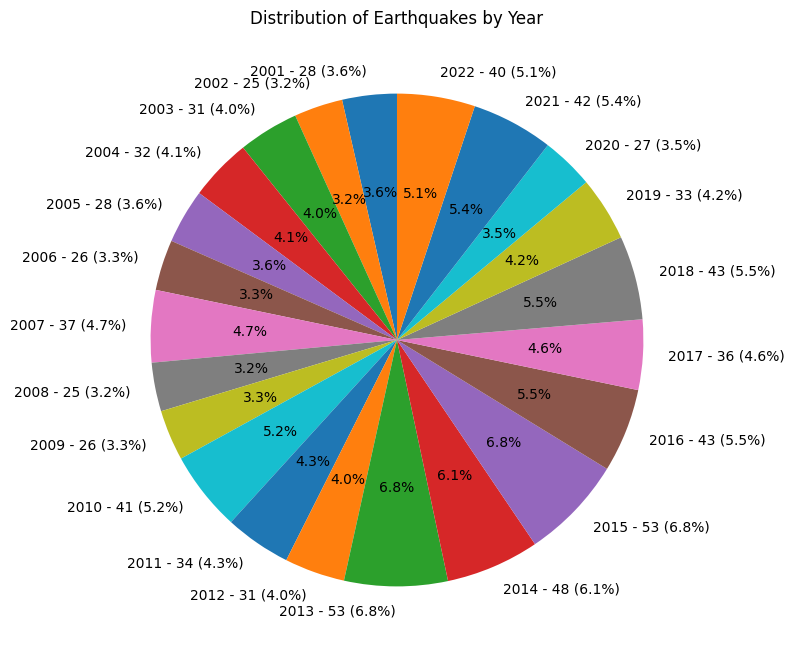

In [394]:
# Distribución de terremotos por año
total_earthquakes = len(df)
earthquakes_by_year = df["magnitude"].resample("YE").count()
percentages = (earthquakes_by_year / total_earthquakes) * 100

labels = [f"{int(year)} - {count} ({p:.1f}%)" for year, count, p in zip(
    earthquakes_by_year.index.year, earthquakes_by_year, percentages)]

plt.figure(figsize=(8,8))
plt.pie(earthquakes_by_year, labels=labels, startangle=90, autopct="%1.1f%%")
plt.title("Distribution of Earthquakes by Year")
plt.show()


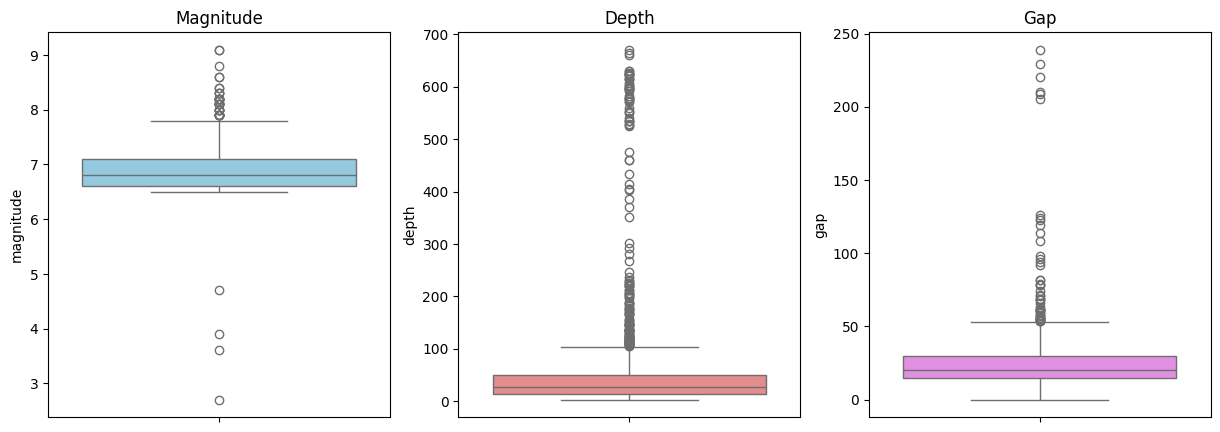

In [395]:
fig, axes = plt.subplots(1, 3, figsize=(15,5))
sns.boxplot(y=df["magnitude"], ax=axes[0], color="skyblue")
sns.boxplot(y=df["depth"], ax=axes[1], color="lightcoral")
sns.boxplot(y=df["gap"], ax=axes[2], color="violet")
axes[0].set_title("Magnitude"); axes[1].set_title("Depth"); axes[2].set_title("Gap")
plt.show()

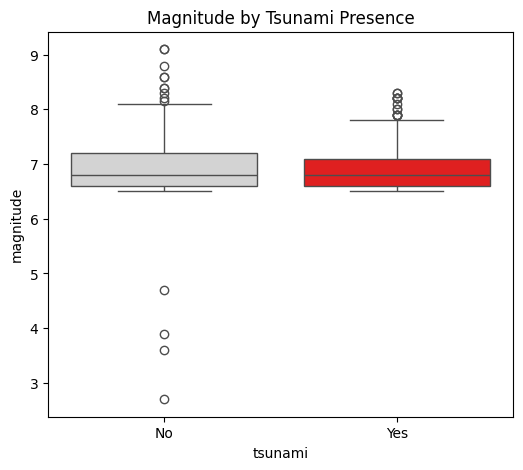

In [396]:
fig, ax = plt.subplots(figsize=(6,5))
colors = ["lightgray" if t==0 else "red" for t in sorted(df["tsunami"].unique())]
sns.boxplot(data=df, x="tsunami", y="magnitude", hue="tsunami", legend=False, palette=colors, ax=ax)
plt.title("Magnitude by Tsunami Presence")
plt.xticks([0,1], ["No", "Yes"])
plt.show()

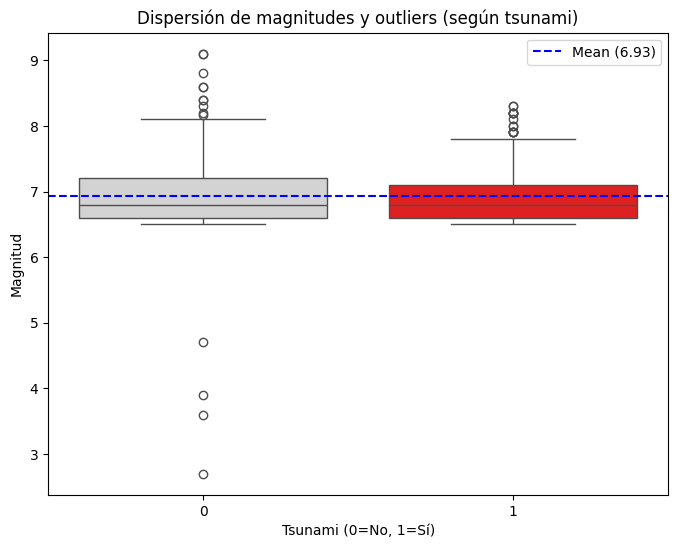

In [397]:
# Visualizar la dispersión y los outliers
plt.figure(figsize=(8,6))
sns.boxplot(data=df, x="tsunami", y="magnitude", hue="tsunami", 
            palette={0:"lightgray",1:"red"}, legend=False)
plt.axhline(mean_mag, color="blue", linestyle="--", label=f"Mean ({mean_mag:.2f})")
plt.title("Dispersión de magnitudes y outliers (según tsunami)")
plt.xlabel("Tsunami (0=No, 1=Sí)")
plt.ylabel("Magnitud")
plt.legend()
plt.show()

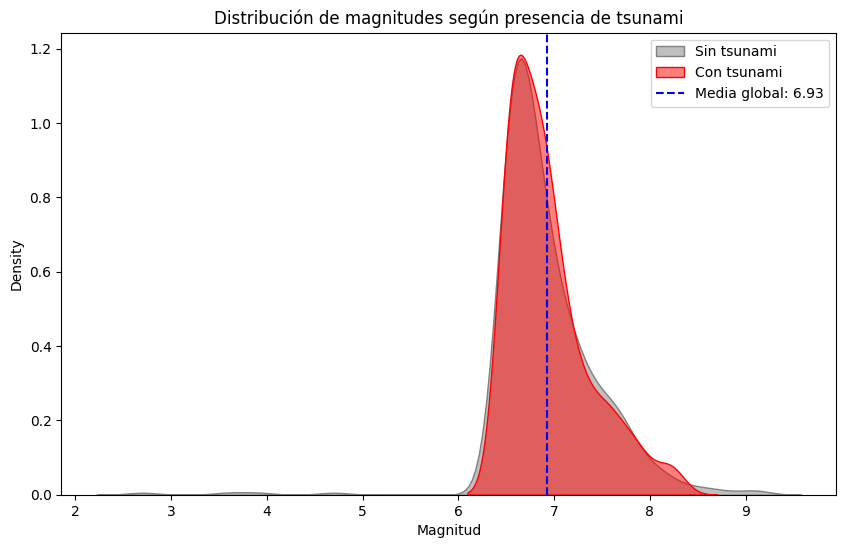

In [398]:
plt.figure(figsize=(10,6))
sns.kdeplot(data=df[df["tsunami"]==0]["magnitude"], fill=True, label="Sin tsunami", color="gray", alpha=0.5)
sns.kdeplot(data=df[df["tsunami"]==1]["magnitude"], fill=True, label="Con tsunami", color="red", alpha=0.5)
plt.axvline(mean_mag, color="blue", linestyle="--", label=f"Media global: {mean_mag:.2f}")
plt.title("Distribución de magnitudes según presencia de tsunami")
plt.xlabel("Magnitud")
plt.legend()
plt.show()

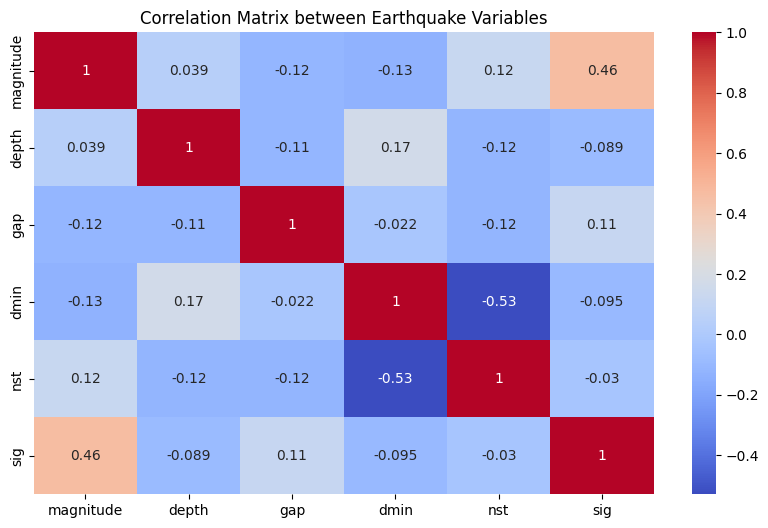

In [399]:
# Heatmap de correlaciones
plt.figure(figsize=(10,6))
sns.heatmap(df[["magnitude","depth","gap","dmin","nst","sig"]].corr(), annot=True, cmap="coolwarm")
plt.title("Correlation Matrix between Earthquake Variables")
plt.show()